In [1]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


In [2]:
indicators = ['90201','90335','90358','90626','90640']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [3]:
if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")

In [4]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90335] + df_munic[90358] + df_munic[90626] + df_munic[90640]
df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

In [5]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [6]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [7]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

In [8]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [9]:
df_munic.shape

(144, 6)

In [10]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1))
#scaler2 = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
scaler2 = preprocessing.RobustScaler()
#scaler2 = preprocessing.StandardScaler()


d1 = scaler2.fit_transform(df_munic.iloc[:,2:3])
d2 = scaler1.fit_transform(df_munic.iloc[:,3:4])
d3 = scaler2.fit_transform(df_munic.iloc[:,4:5])
d4 = scaler1.fit_transform(df_munic.iloc[:,5:6])


ds = [d1, d2, d3, d4]

scaled_df = pd.DataFrame()
cont = 2
for i in ds:

    s_df = pd.DataFrame(i, columns=df_munic.iloc[:,cont:cont+1].columns)
    scaled_df = pd.concat([scaled_df, s_df], axis=1)
    cont += 1

scaled_df = pd.concat([df_munic.iloc[:,:2], scaled_df], axis=1)
scaled_df


,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,2.4,0.841823,-0.165936,0.816327
1,150013,Abel Figueiredo,0.0,0.833780,0.084722,0.755102
2,150020,Acará,1.6,0.678284,0.360953,0.734694
3,150030,Afuá,1.6,0.655496,-0.172710,0.795918
4,150034,Água Azul do Norte,0.0,0.756032,0.646723,0.755102
...,...,...,...,...,...,...
139,150815,Uruará,0.0,0.789544,0.337709,0.775510
140,150820,Vigia,-0.8,0.827078,-0.452450,0.734694
141,150830,Viseu,0.0,0.690349,-0.358380,0.755102
142,150835,Vitória do Xingu,2.4,0.798928,33.172137,0.775510


In [11]:
scaled_df.describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,144.000000,144.000000,1.440000e+02,144.000000
mean,0.311111,0.774138,9.366207e-01,0.761196
std,0.946625,0.099055,4.266821e+00,0.081778
min,-0.800000,0.000000,-6.855955e-01,0.000000
25%,-0.200000,0.732909,-3.198346e-01,0.734694
50%,0.000000,0.780831,-1.162265e-16,0.775510
75%,0.800000,0.822386,6.801654e-01,0.795918
max,3.200000,1.000000,3.550287e+01,1.000000


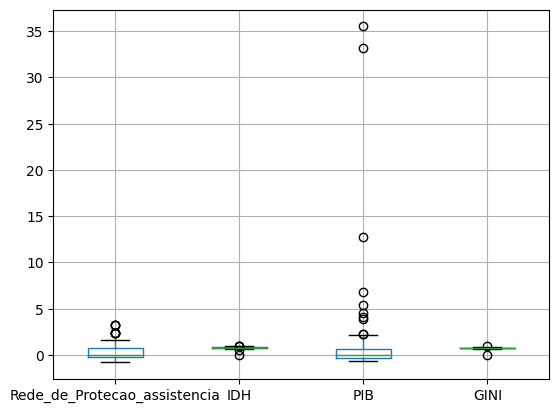

array([[-8.00000000e-01,  6.07238606e-01, -6.85595529e-01,
         6.73469388e-01],
       [-2.00000000e-01,  7.32908847e-01, -3.19834648e-01,
         7.34693878e-01],
       [ 0.00000000e+00,  7.80831099e-01, -1.16226473e-16,
         7.75510204e-01],
       [ 8.00000000e-01,  8.22386059e-01,  6.80165352e-01,
         7.95918367e-01],
       [ 1.60000000e+00,  9.26273458e-01,  2.16318383e+00,
         8.77551020e-01]])

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")
    
    
def print_limits(dataset) -> np.array:

    res = np.zeros((5, 4))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    plt.show()

    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]

        

        res[0][cont] = lower_range
        res[1][cont] = Q1
        res[2][cont] = M
        res[3][cont] = Q3
        res[4][cont] = upper_range

        cont += 1
    
    
    return res
         

print_limits(scaled_df.iloc[:,2:6])

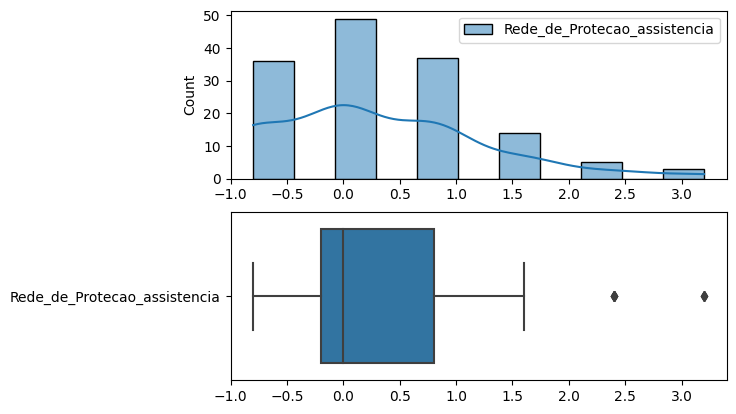

In [13]:

dplot = scaled_df.iloc[:,2:3]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
#plt.xlim(-1, 1)
plt.show()

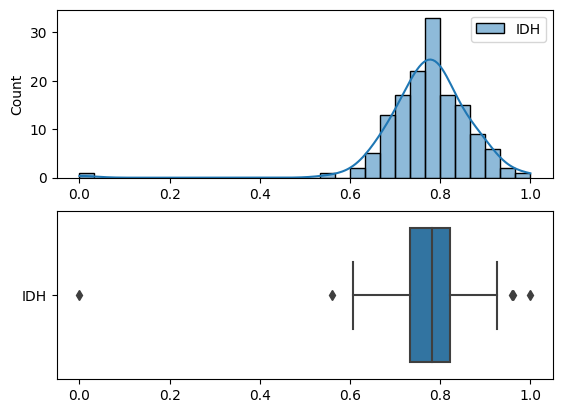

In [14]:
dplot = scaled_df.iloc[:,3:4]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

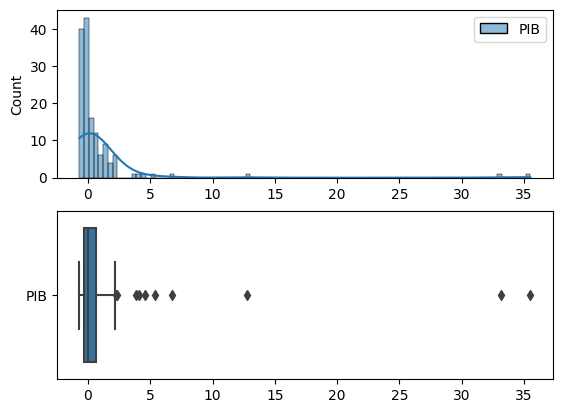

In [15]:
dplot = scaled_df.iloc[:,4:5]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

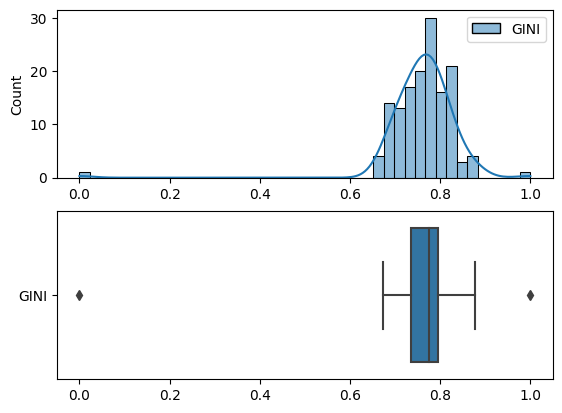

In [16]:
dplot = scaled_df.iloc[:,5:6]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

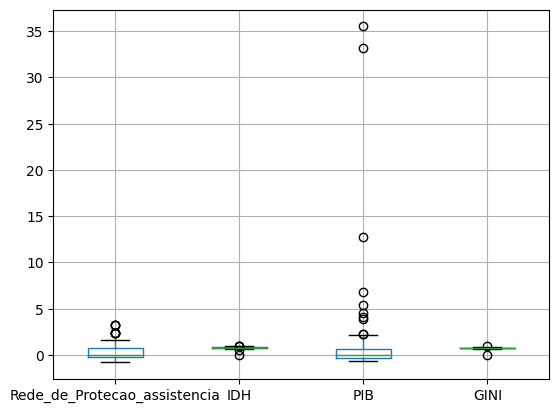

array([[-8.00000000e-01,  6.07238606e-01, -6.85595529e-01,
         6.73469388e-01],
       [-2.00000000e-01,  7.32908847e-01, -3.19834648e-01,
         7.34693878e-01],
       [ 0.00000000e+00,  7.80831099e-01, -1.16226473e-16,
         7.75510204e-01],
       [ 8.00000000e-01,  8.22386059e-01,  6.80165352e-01,
         7.95918367e-01],
       [ 1.60000000e+00,  9.26273458e-01,  2.16318383e+00,
         8.77551020e-01]])

In [17]:
     #IP       #IDH      #PIB      #GINI
Q = [0.05,      0.05,       0.05,      0.05]
P = [0.08,      0.08,       0.08,      0.08]
V = [2.0,      2.0,       2.0,      2.0]
W = [0.5,      0.5,       0.5,      0.5]

B = print_limits(scaled_df.iloc[:,2:6]).tolist()
#B = print_limits(df_munic.iloc[:,2:6]).tolist()

np.array(B)

In [18]:
#df_munic.query('Rede_de_Protecao_assistencia < 0.15')
scaled_df.query('Rede_de_Protecao_assistencia < 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
5,150040,Alenquer,-0.8,0.756032,-0.085159,0.795918
6,150050,Almeirim,-0.8,0.860590,0.660882,1.000000
7,150060,Altamira,-0.8,0.891421,1.720920,0.816327
10,150085,Anapu,-0.8,0.734584,0.527742,0.816327
12,150095,Aurora do Pará,-0.8,0.695710,-0.474722,0.734694
16,150125,Bannach,-0.8,0.796247,1.773716,0.775510
19,150145,Belterra,-0.8,0.788204,-0.198384,0.693878
25,150175,Brejo Grande do Araguaia,-0.8,0.792225,0.037641,0.775510
29,150195,Cachoeira do Piriá,-0.8,0.634048,-0.685596,0.714286
42,150280,Curralinho,-0.8,0.672922,-0.434923,0.795918


In [19]:
T = scaled_df.iloc[:, 2:].values

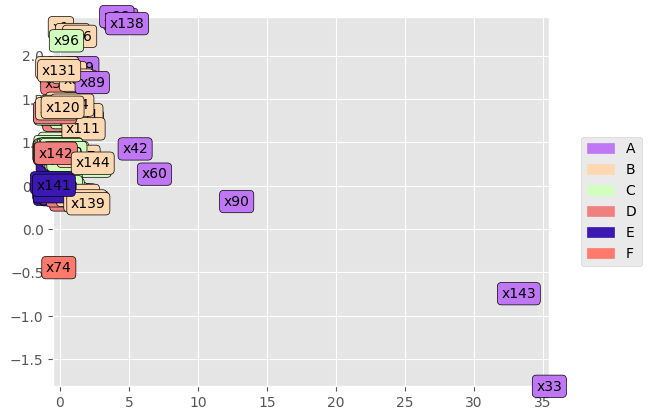

In [20]:
from pyDecision.algorithm import electre_tri_b

classification = electre_tri_b(T, W , Q , P , V , B, cut_level = 0.6, verbose = False, rule = 'oc', graph = True)

In [21]:
classification.count(0)

10

In [22]:
scaled_df['CLASS'] = classification

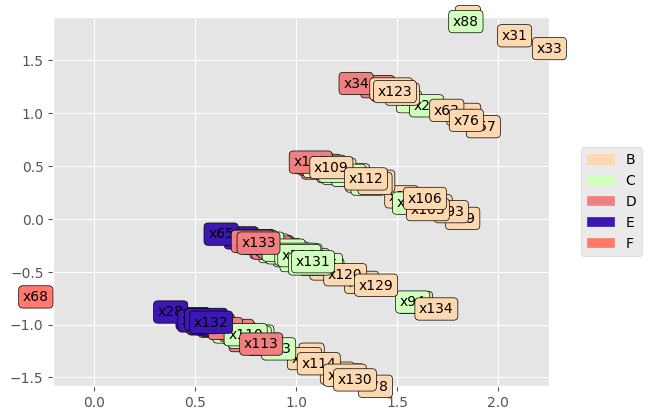

In [23]:
df__ = scaled_df.query('CLASS != 0')

df_ = df__.iloc[:, 2:6]


c = electre_tri_b(np.array(df_), W , Q , P , V , B, cut_level = 0.6, verbose = False, rule = 'oc', graph = True)


In [24]:
scaled_df = scaled_df.rename(index=lambda s: 'x' + str(s + 1))

In [25]:
scaled_df.query('CLASS == 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
x18,150130,Barcarena,3.2,0.887399,4.122785,0.836735,0
x19,150140,Belém,1.6,1.000000,1.396257,0.877551,0
x33,150215,Canaã dos Carajás,0.8,0.902145,35.502867,0.734694,0
x42,150277,Curionópolis,0.8,0.852547,5.346409,0.795918,0
x60,150375,Jacareacanga,0.8,0.676944,6.765303,0.693878,0
x66,150420,Marabá,3.2,0.895442,3.842125,0.836735,0
x89,150550,Paragominas,1.6,0.864611,2.163184,0.836735,0
x90,150553,Parauapebas,0.8,0.958445,12.734427,0.795918,0
x138,150810,Tucuruí,3.2,0.892761,4.584063,0.816327,0
x143,150835,Vitória do Xingu,2.4,0.798928,33.172137,0.775510,0


In [26]:
import geopandas as gpd

gdf_munic = gpd.read_file('json/munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(scaled_df, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

In [27]:
clusdict={5: '1 - Extremely High', 4: '2 - Very High', 3: '3 - High', 2: '4 - Medium', 1: '5 - Low', 0: '6 - Very Low' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='prism')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

In [28]:
denuncias = pd.read_json('json/casos_violencia_por_municipio.json')
denuncias = denuncias.rename(index=lambda s: 'x' + str(s + 1))

scaled_df['denuncias'] = denuncias['casos']

In [29]:
scaled_df

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS,denuncias
x1,150010,Abaetetuba,2.4,0.841823,-0.165936,0.816327,1,77
x2,150013,Abel Figueiredo,0.0,0.833780,0.084722,0.755102,2,0
x3,150020,Acará,1.6,0.678284,0.360953,0.734694,2,11
x4,150030,Afuá,1.6,0.655496,-0.172710,0.795918,3,1
x5,150034,Água Azul do Norte,0.0,0.756032,0.646723,0.755102,1,4
...,...,...,...,...,...,...,...,...
x140,150815,Uruará,0.0,0.789544,0.337709,0.775510,2,2
x141,150820,Vigia,-0.8,0.827078,-0.452450,0.734694,4,10
x142,150830,Viseu,0.0,0.690349,-0.358380,0.755102,3,4
x143,150835,Vitória do Xingu,2.4,0.798928,33.172137,0.775510,0,6


In [30]:
data = scaled_df

sns.set_style("whitegrid")
 
# depict visualization
gfg = sns.boxplot(x="Rede_de_Protecao_assistencia", y="denuncias", data=data, palette='hot_r')

gfg.set_ylim(0, 120)
gfg.set(xlabel ="Support and Protection Index (IAP)", ylabel = "Denunciations")



[Text(0.5, 89.68626392038504, 'Support and Protection Index (IAP)'),
 Text(80.47222222222221, 0.5, 'Denunciations')]